#**EXTRACCIÓN DE CARACTERISTICAS**

# Descripción de Librerías Utilizadas

Este proyecto utiliza las siguientes librerías para el procesamiento de imágenes de variedades nativas de papas:

1. **os**: Permite la interacción con el sistema operativo para manipular rutas de archivos y directorios.

2. **cv2 (OpenCV)**: Proporciona herramientas avanzadas de visión por computadora, facilitando la lectura, el procesamiento y la segmentación de imágenes.

3. **numpy**: Ofrece soporte para operaciones matemáticas y manipulación de arreglos, fundamental para el manejo eficiente de datos en el proyecto.

4. **pandas**: Se utiliza para la manipulación y análisis de datos, permitiendo trabajar con DataFrames y facilitar la exportación de resultados a archivos CSV.

5. **skimage.feature (Scikit-Image)**: Proporciona funciones para la extracción de características de textura a través de la matriz de co-ocurrencia de niveles de gris (GLCM).

6. **mahotas**: Incluye algoritmos de procesamiento de imágenes y extracción de características, como los momentos de Haralick, que son útiles para describir la textura de las imágenes.

7. **pathlib**: Facilita la manipulación de rutas de archivos de manera orientada a objetos, mejorando la legibilidad y mantenimiento del código.

8. **matplotlib.pyplot**: Utilizada para la visualización de imágenes y gráficos, permite presentar visualmente los resultados del procesamiento.

9. **sklearn.cluster (KMeans)**: Proporciona la implementación del algoritmo K-means para la agrupación de colores en las imágenes, permitiendo identificar colores predominantes en las muestras.

Estas librerías son esenciales para llevar a cabo las tareas de procesamiento y análisis de imágenes, así como para la organización y visualización de los resultados obtenidos.


# Características Extraídas de las Imágenes de Papas Nativas

El siguiente código procesa imágenes de papas nativas y extrae las siguientes características:

## 1. Características de Forma
- **Área:** Área del contorno de la papa.
- **Perímetro:** Longitud del contorno.
- **Relación de Aspecto:** Proporción entre el ancho y la altura del contorno.
- **Extent:** Relación entre el área del contorno y el área del rectángulo delimitador.
- **Circularidad:** Medida de cuán cerca está la forma del contorno de ser un círculo perfecto.
- **Momentos de Hu:** Siete momentos de Hu, invariantes a escala, rotación y traslación.

## 2. Características de Color
Para cada uno de los espacios de color (BGR, HSV y LAB):
- **Media:** Promedio de los valores de píxeles.
- **Desviación estándar:** Medida de la dispersión de los valores de píxeles.
- **Percentil 25:** Valor en el que el 25% de los píxeles tienen un valor menor.
- **Percentil 75:** Valor en el que el 75% de los píxeles tienen un valor menor.

## 3. Características de Textura
- **GLCM (Matriz de Co-ocurrencia de Niveles de Gris):**
  - **Contraste**
  - **Disimilitud**
  - **Homogeneidad**
  - **Energía**
  - **Correlación**
- **Características de Haralick:** 13 características relacionadas con la textura.

## 4. Color Predominante
- **KMeans:** Extrae el color predominante de la imagen, devolviendo el color promedio de los clusters encontrados.

## Resumen de la Salida
Cada imagen procesada produce un vector de características que incluye:
- **12 características de forma.**
- **36 características de color** (3 espacios de color × 4 métricas por espacio).
- **5 características de textura** (GLCM).
- **13 características de textura de Haralick.**
- **3 características de color predominante** (R, G, B).

En total, se generan **66 características por imagen**, además de su etiqueta y nombre de imagen que se almacenan en un DataFrame y se guardan en un archivo CSV.


In [ ]:
!pip install scikit-image mahotas opencv-python-headless

In [ ]:
!pip install opencv-python numpy pandas scikit-image mahotas matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
import mahotas
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from google.colab import drive

class ProcesadorPapaNativa:
    def __init__(self):
        self.caracteristicas = []
        self.etiquetas = []
        self.nombres_imagenes = []
        self.imagenes_fallidas = []

    def visualizar_procesamiento(self, imagen, binaria, contorno, mascara):
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        axes[0, 0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Imagen Original')

        axes[0, 1].imshow(binaria, cmap='gray')
        axes[0, 1].set_title('Segmentación')

        img_contorno = imagen.copy()
        cv2.drawContours(img_contorno, [contorno], -1, (0, 255, 0), 2)
        axes[1, 0].imshow(cv2.cvtColor(img_contorno, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('Contorno Detectado')

        axes[1, 1].imshow(mascara, cmap='gray')
        axes[1, 1].set_title('Máscara')

        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def preprocesar_imagen(self, imagen):
        max_dim = 800
        height, width = imagen.shape[:2]
        if max(height, width) > max_dim:
            scale = max_dim / max(height, width)
            imagen = cv2.resize(imagen, None, fx=scale, fy=scale)

        imagen = cv2.GaussianBlur(imagen, (5, 5), 0)
        return imagen

    def extraer_caracteristicas_forma(self, contorno):
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        x, y, w, h = cv2.boundingRect(contorno)
        aspect_ratio = float(w) / h
        extent = float(area) / (w * h) if (w * h) > 0 else 0
        circularidad = 4 * np.pi * area / (perimetro * perimetro) if perimetro > 0 else 0

        momentos = cv2.moments(contorno)
        hu_moments = cv2.HuMoments(momentos).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

        return [area, perimetro, aspect_ratio, extent, circularidad] + list(hu_moments)

    def extraer_caracteristicas_color(self, imagen, mascara):
        hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

        caracteristicas_color = []

        for espacio in [imagen, hsv, lab]:
            for i in range(3):
                canal = espacio[:, :, i]
                pixels = canal[mascara > 0]

                if len(pixels) > 0:
                    caracteristicas_color.extend([
                        np.mean(pixels),
                        np.std(pixels),
                        np.percentile(pixels, 25),
                        np.percentile(pixels, 75)
                    ])
                else:
                    caracteristicas_color.extend([0, 0, 0, 0])

        return caracteristicas_color

    def extraer_caracteristicas_textura(self, imagen_gris, mascara):
        roi = imagen_gris.copy()
        roi[mascara == 0] = 0

        distancias = [1]
        angulos = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

        glcm = graycomatrix(roi, distances=distancias, angles=angulos,
                            levels=256, symmetric=True, normed=True)

        propiedades = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

        caracteristicas_glcm = []
        for prop in propiedades:
            valor = graycoprops(glcm, prop).mean()
            caracteristicas_glcm.append(valor)

        haralick = mahotas.features.haralick(roi).mean(axis=0)[:13]

        return list(caracteristicas_glcm) + list(haralick)

    def extraer_color_predominante(self, imagen, n_colores=5):
        image = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        pixels = image.reshape(-1, 3)

        kmeans = KMeans(n_clusters=n_colores)
        kmeans.fit(pixels)

        colores = kmeans.cluster_centers_.astype(int)

        return colores.mean(axis=0)  # Devolver el color promedio

    def contar_ojos(self, imagen, mascara):
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        eye_count = 0
        for contorno in contornos:
            if cv2.contourArea(contorno) > 100:  # Ajusta este valor según sea necesario
                eye_count += 1

        return eye_count

    def procesar_imagen(self, ruta_imagen, visualizar=False):
        try:
            imagen = cv2.imread(ruta_imagen)
            if imagen is None:
                raise ValueError(f"No se pudo leer la imagen: {ruta_imagen}")

            imagen = self.preprocesar_imagen(imagen)

            gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
            _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

            if not contornos:
                raise ValueError(f"No se encontraron contornos en: {ruta_imagen}")

            contorno = max(contornos, key=cv2.contourArea)

            mascara = np.zeros(gris.shape, dtype=np.uint8)
            cv2.drawContours(mascara, [contorno], -1, 255, -1)

            if visualizar:
                self.visualizar_procesamiento(imagen, binaria, contorno, mascara)

            caract_forma = self.extraer_caracteristicas_forma(contorno)
            caract_color = self.extraer_caracteristicas_color(imagen, mascara)
            caract_textura = self.extraer_caracteristicas_textura(gris, mascara)

            color_predominante = self.extraer_color_predominante(imagen)
            num_ojos = self.contar_ojos(imagen, mascara)

            print(f"Características de forma: {len(caract_forma)}, color: {len(caract_color)}, textura: {len(caract_textura)}")

            return caract_forma + caract_color + caract_textura + list(color_predominante) + [num_ojos]

        except Exception as e:
            print(f"Error procesando {ruta_imagen}: {str(e)}")
            self.imagenes_fallidas.append((ruta_imagen, str(e)))
            return None

    def procesar_dataset(self, directorio_base, visualizar_primeras=False):
        print(f"Iniciando procesamiento del dataset en: {directorio_base}")
        total_procesadas = 0

        # Lista de carpetas (números del 1 al 88)
        carpetas = range(1, 89)

        for i in carpetas:
            ruta_carpeta = os.path.join(directorio_base, str(i))

            # Verificar si la carpeta existe
            if not os.path.exists(ruta_carpeta):
                print(f'Carpeta no encontrada: {ruta_carpeta}, se omite.')
                continue  # Omitir esta carpeta y pasar a la siguiente

            print(f"Procesando carpeta: {i}")
            for imagen_path in Path(ruta_carpeta).glob("*.jpg"):
                print(f"Procesando imagen: {imagen_path.name}")
                visualizar = visualizar_primeras and total_procesadas < 2

                vector = self.procesar_imagen(str(imagen_path), visualizar)

                if vector is not None:
                    expected_length = 66 + 3 + 1  # 12 (forma) + 36 (color) + 18 (textura) + 3 (color predominante) + 1 (número de ojos)

                    if len(vector) == expected_length:
                        self.caracteristicas.append(vector)
                        self.etiquetas.append(imagen_path.stem)
                        self.nombres_imagenes.append(imagen_path.name)
                        total_procesadas += 1
                    else:
                        print(f"Vector de características de tamaño inesperado para {imagen_path.name}: {len(vector)}")

                if total_procesadas % 10 == 0 and total_procesadas > 0:
                    print(f"Procesadas {total_procesadas} imágenes...")

        print(f"Total de imágenes procesadas: {total_procesadas}")

        if not self.caracteristicas:
            print("No hay características para guardar.")
            return

        # Guardar características en un DataFrame
        nombres_columnas = (
            ['area', 'perimetro', 'aspect_ratio', 'extent', 'circularidad'] +
            [f'hu_moment_{i+1}' for i in range(7)] +
            ['media_r', 'std_r', 'percentil_25_r', 'percentil_75_r'] * 9 +
            [f'glcm_{prop}' for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] +
            [f'haralick_{i+1}' for i in range(13)] +
            ['color_predominante_r', 'color_predominante_g', 'color_predominante_b', 'num_ojos']
        )

        df_caracteristicas = pd.DataFrame(self.caracteristicas, columns=nombres_columnas)
        df_caracteristicas['etiqueta'] = self.etiquetas
        df_caracteristicas['nombre_imagen'] = self.nombres_imagenes

        df_caracteristicas.to_csv('caracteristicas_papa_nativa.csv', index=False)
        print("Características guardadas en 'caracteristicas_papa_nativa.csv'")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando procesamiento del dataset en: /content/drive/MyDrive/imagenes-Papas/imagenes/
Procesando carpeta: 1
Procesando imagen: 1 (1).jpg


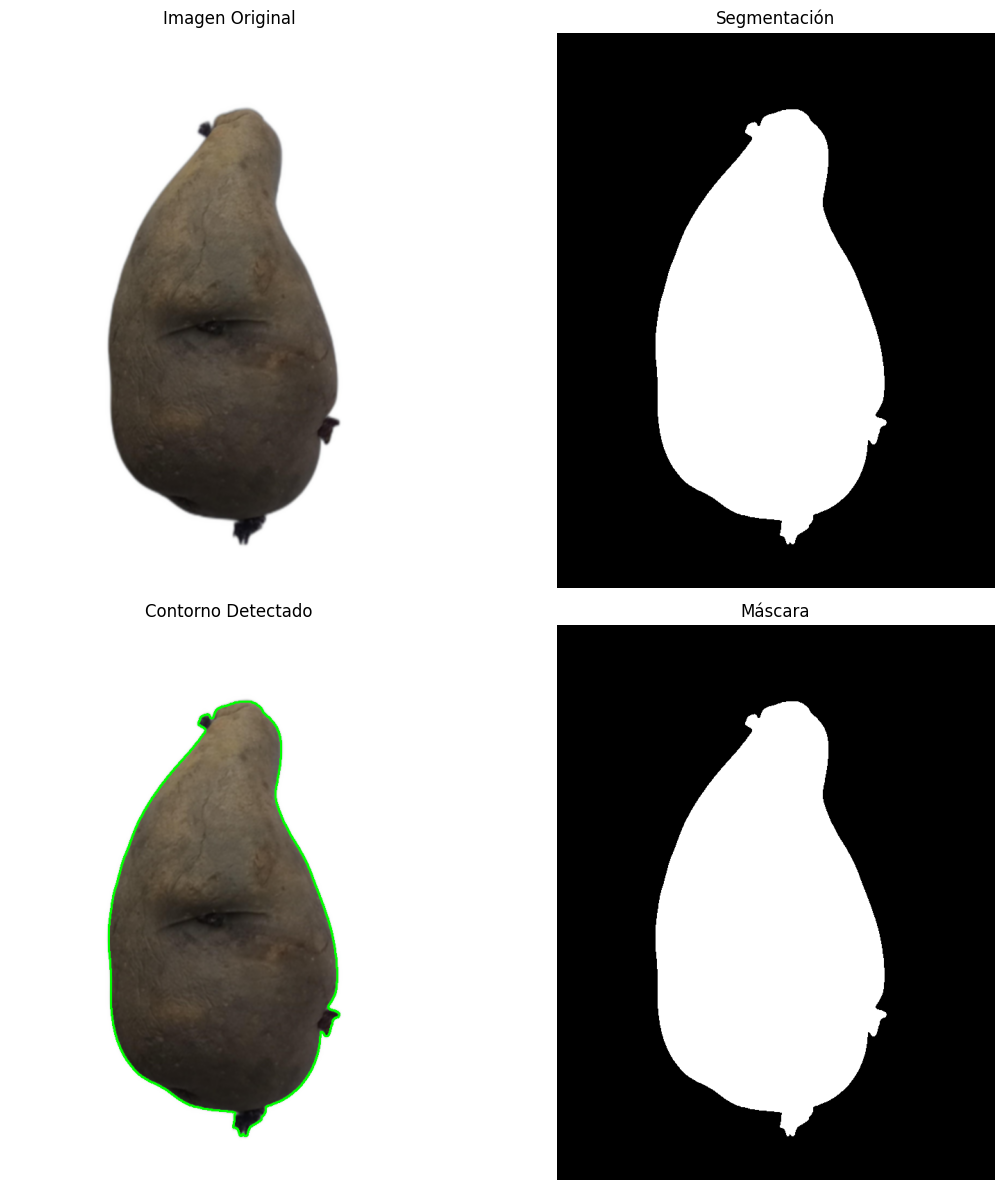

Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (2).jpg


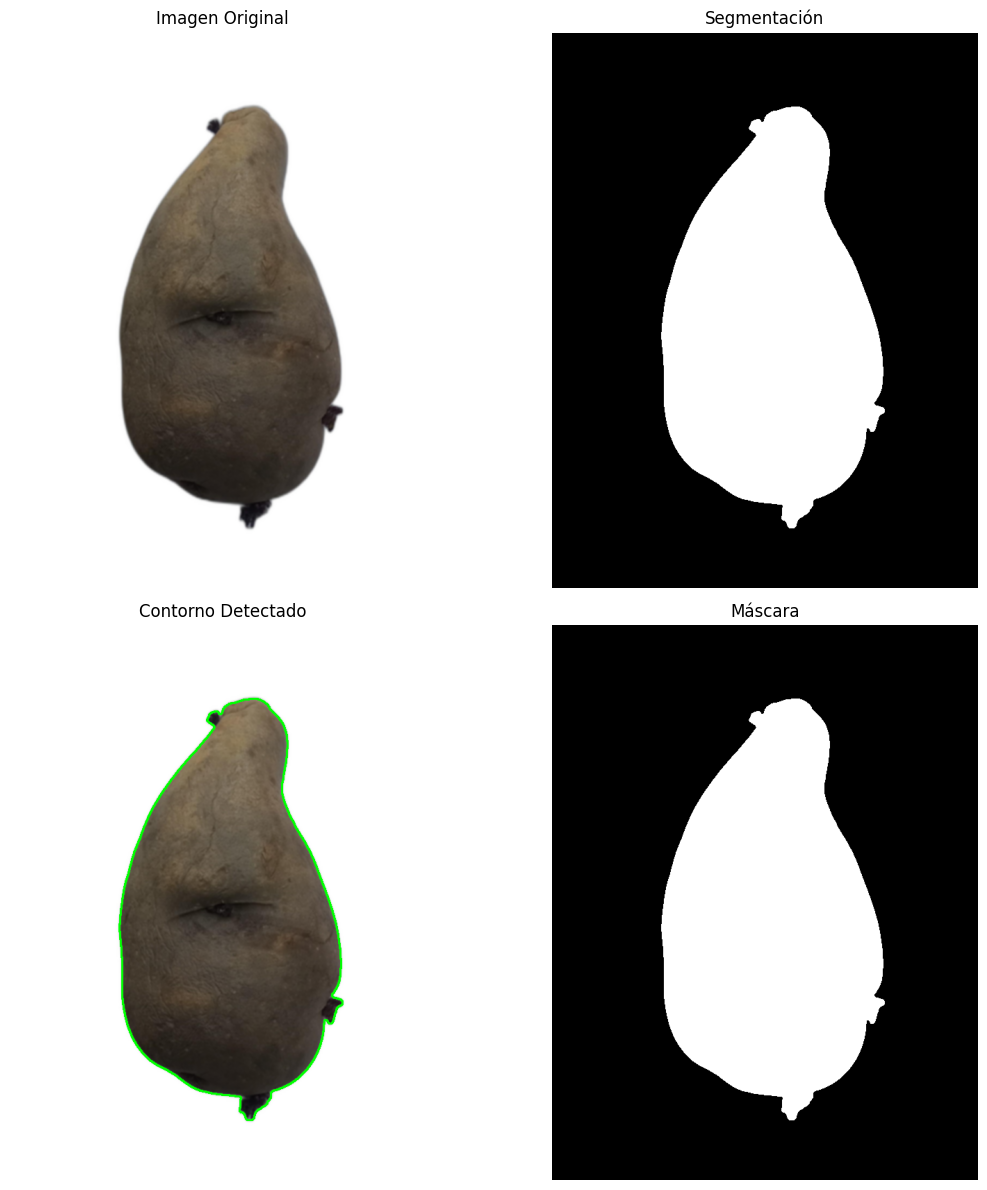

Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (3).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (4).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (5).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (6).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (7).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (8).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (9).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (10).jpg
Características de forma: 12, color: 36, textura: 18
Procesadas 10 imágenes...
Procesando imagen: 1 (11).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (12).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (13).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imag

In [ ]:
if __name__ == "__main__":
    # Montar Google Drive
    drive.mount('/content/drive')

    procesador = ProcesadorPapaNativa()

    # Ruta a la carpeta que contiene las subcarpetas
    ruta_base = '/content/drive/MyDrive/imagenes-Papas/imagenes/'

    # Procesar el dataset en la ruta base
    procesador.procesar_dataset(ruta_base, visualizar_primeras=True)

